<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# **Capstone Project: Audio Classification Of Emotions**

# Modeling on MFCC


In [1]:
#Mount Drive

from google.colab import drive
drive.mount('/content/My_Drive/')

Drive already mounted at /content/My_Drive/; to attempt to forcibly remount, call drive.mount("/content/My_Drive/", force_remount=True).


## Imports

In [2]:
#Import basic, plotting libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns


%matplotlib inline

#Import SK-Learn Libraries
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as R_Forest
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier as KNNClassifier
from sklearn import svm
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler

#Import Keras Layers
import keras
from keras import layers
from keras import models
from keras.layers import GlobalAveragePooling1D, Dense, MaxPooling1D, Conv1D, Flatten, Dropout
from keras.models import Sequential
from keras.layers.core import Activation, Dense 
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from keras.layers import GaussianNoise


## Functions

In [3]:
def cf_matrix(y_preds, y_test):
  '''This function creates a confusion matrix on our data'''
  
  cf_matrix = confusion_matrix(y_preds, y_test)
  labels = ['Angry', 'Calm', 'Disgust', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Suprised']
  fig, ax = plt.subplots(figsize=(15,10)) 
  sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g', cmap="OrRd")
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

In [4]:
#Set a random seed for reproducibility.
np.random.seed(42)

In [5]:
#Read_CSV
df = pd.read_csv('MFCC_Data.csv')

In [6]:
#Encoded Labels
levels = ['Angry', 'Calm', 'Disgust', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Suprised']

#Show dataframe
df.head(2)



,path,actor,emotion_id,intensity,stated_text,gender,source,emotion,label,encoded_label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,03-01-05-01-02-01-16.wav,16,5,Normal,Dogs are sitting by the door,Female,RAVDESS,Angry,Angry,0,-493.219055,49.73700,-10.452538,9.418360,-18.108517,-2.562056,-15.887474,-10.313912,-19.508406,2.387971,-13.172427,-4.483107,-7.110461,-4.474319,-10.150778,-4.960736,-4.617444,-7.545546,-8.921757,-2.188476,-6.765614,0.304586,-3.479743,0.658508,-4.971695,-1.568901,-1.941403,-2.932507,2.131908,4.724022,5.060043,4.515399,-0.391671,0.927307,0.080814,3.378861,1.079824,2.299387,-0.806499,2.516651
1,03-01-06-01-02-02-16.wav,16,6,Normal,Dogs are sitting by the door,Female,RAVDESS,Fearful,Fearful,3,-524.782166,48.70853,-11.586839,9.986774,-6.686351,-6.897908,-21.218477,-13.014283,-13.422829,4.108604,-17.836227,-6.692956,-0.580142,-5.878499,-8.971943,-3.641211,-7.910971,-2.756809,-5.727985,-4.638661,-0.558540,1.017308,2.308388,4.668447,1.556933,6.395074,0.865194,1.460632,0.454776,-1.013651,0.145559,0.042050,-0.788098,0.209579,-0.648037,0.825450,0.246961,1.108818,0.153405,0.344702


In [7]:
le = LabelEncoder()
df['encoded_label']= le.fit_transform(df['label'])

In [8]:
#Select X and y features
X = df.iloc[:, 10:].values
y = df['encoded_label'].values

print(X.shape)
print(y.shape)

(1440, 40)
(1440,)


In [9]:
#Add as array
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((1440, 40), (1440,))

In [10]:
#Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle = True)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1080, 40), (1080,), (360, 40), (360,))

In [11]:
#Scale X_training Data
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [12]:
#Expand dimensions for nueral net
X_train_sc_1 = np.expand_dims(X_train_sc, axis=2)
X_test_sc_1 = np.expand_dims(X_test_sc, axis=2)

X_train_sc_1.shape, X_test_sc_1.shape

((1080, 40, 1), (360, 40, 1))

## Models

In [13]:
SVM = svm.SVC()

In [14]:
SVM.fit(X_train_sc, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [15]:
y_predSVM = SVM.predict(X_test_sc)

In [16]:
print(classification_report(y_test,y_predSVM,target_names=levels))

              precision    recall  f1-score   support

       Angry       0.83      0.71      0.76        48
        Calm       0.65      0.82      0.72        51
     Disgust       0.62      0.62      0.62        48
     Fearful       0.67      0.66      0.67        47
       Happy       0.65      0.45      0.53        49
     Neutral       0.33      0.04      0.07        26
         Sad       0.43      0.63      0.51        41
    Suprised       0.65      0.80      0.71        50

    accuracy                           0.63       360
   macro avg       0.60      0.59      0.58       360
weighted avg       0.62      0.63      0.61       360



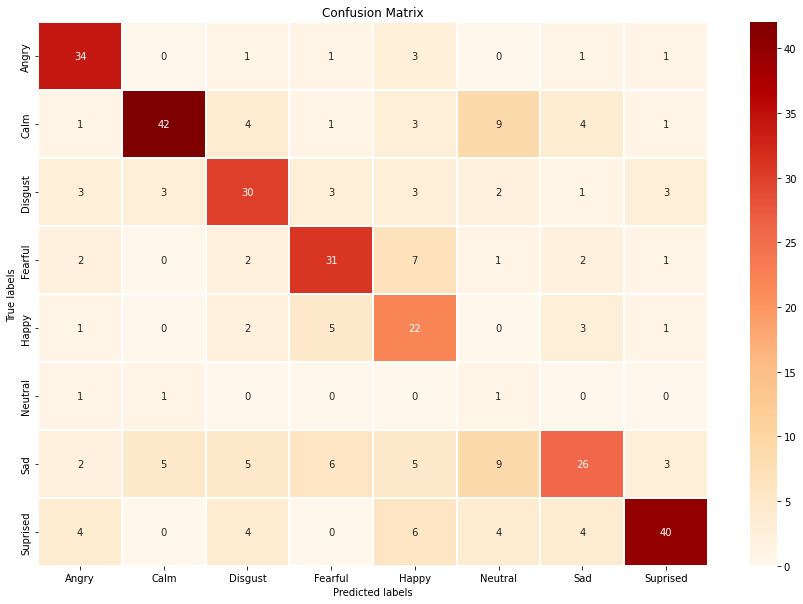

In [17]:
cf_matrix(y_predSVM,y_test)

#### K-Nearest Neighbors

In [18]:
clf = KNNClassifier()
clf.fit(X_train_sc, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [19]:
y_predKNN = clf.predict(X_test_sc)

In [20]:
print(classification_report(y_test,y_predKNN,target_names=levels))

              precision    recall  f1-score   support

       Angry       0.61      0.58      0.60        48
        Calm       0.63      0.90      0.74        51
     Disgust       0.65      0.58      0.62        48
     Fearful       0.48      0.53      0.51        47
       Happy       0.47      0.37      0.41        49
     Neutral       0.50      0.35      0.41        26
         Sad       0.50      0.29      0.37        41
    Suprised       0.62      0.82      0.71        50

    accuracy                           0.57       360
   macro avg       0.56      0.55      0.54       360
weighted avg       0.56      0.57      0.56       360



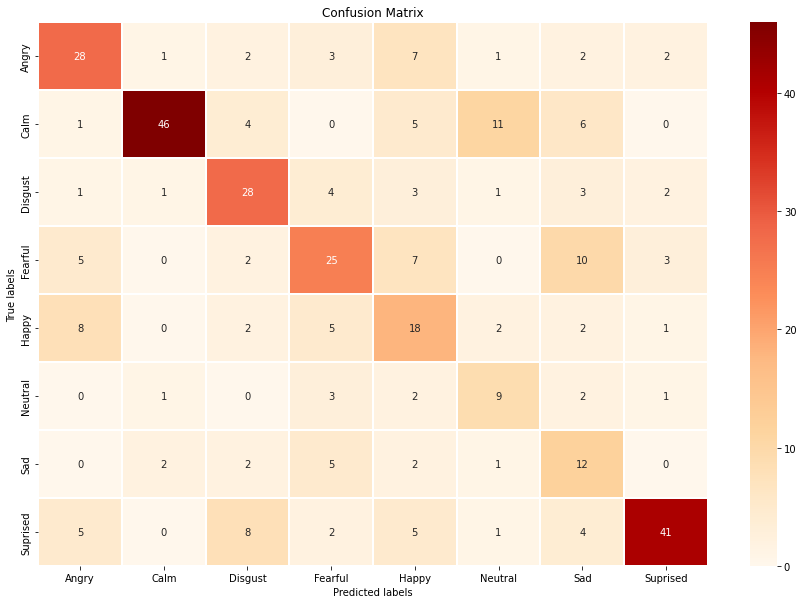

In [21]:
cf_matrix(y_predKNN,y_test)

#### Random Forest Classifier

In [22]:
rforest = R_Forest(criterion="gini", 
                   max_depth=5, 
                   max_features="log2",  
                   min_samples_leaf = 3, 
                   min_samples_split = 20, 
                   n_estimators= 22000, 
                   )

In [23]:
#Fit Random forest
rforest.fit(X_train_sc, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=22000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [24]:
#Get predictions
y_pred = rforest.predict(X_test_sc)


In [25]:
#Print classification report
print(classification_report(y_test,y_pred,target_names=levels))

              precision    recall  f1-score   support

       Angry       0.60      0.58      0.59        48
        Calm       0.51      0.90      0.65        51
     Disgust       0.46      0.48      0.47        48
     Fearful       0.67      0.51      0.58        47
       Happy       0.50      0.27      0.35        49
     Neutral       0.00      0.00      0.00        26
         Sad       0.25      0.32      0.28        41
    Suprised       0.47      0.54      0.50        50

    accuracy                           0.48       360
   macro avg       0.43      0.45      0.43       360
weighted avg       0.46      0.48      0.46       360



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


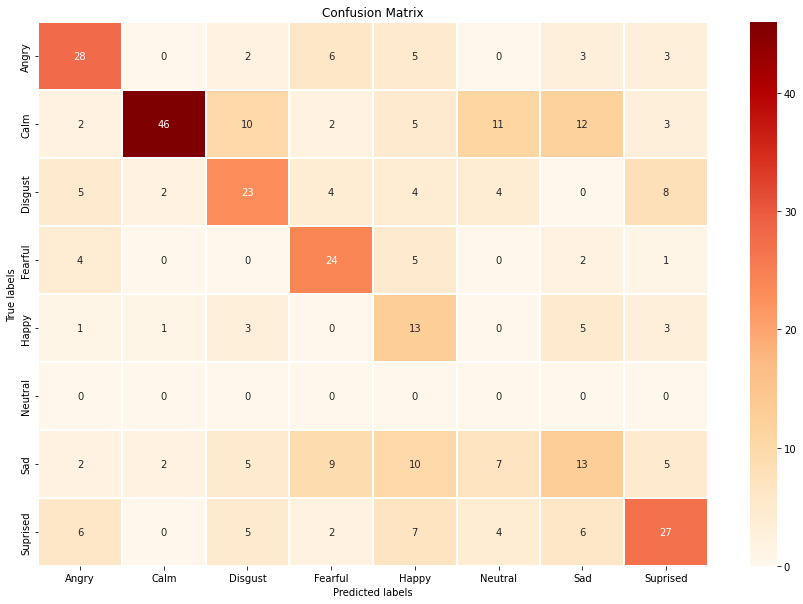

In [26]:
#Plot confusion matrix
cf_matrix(y_pred,y_test)

#### Decision Tree Classifier


In [27]:
#Instantiate decision tree 
dtree = DecisionTreeClassifier()

In [28]:
#Fit decision tree
dtree.fit(X_train_sc, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [29]:
#Predict data
y_preds = dtree.predict(X_test_sc)



In [30]:
#Print classification report
print(classification_report(y_test,y_preds,target_names=levels))

              precision    recall  f1-score   support

       Angry       0.57      0.56      0.57        48
        Calm       0.47      0.45      0.46        51
     Disgust       0.35      0.38      0.36        48
     Fearful       0.45      0.47      0.46        47
       Happy       0.45      0.35      0.39        49
     Neutral       0.30      0.31      0.30        26
         Sad       0.29      0.34      0.31        41
    Suprised       0.41      0.40      0.40        50

    accuracy                           0.41       360
   macro avg       0.41      0.41      0.41       360
weighted avg       0.42      0.41      0.42       360



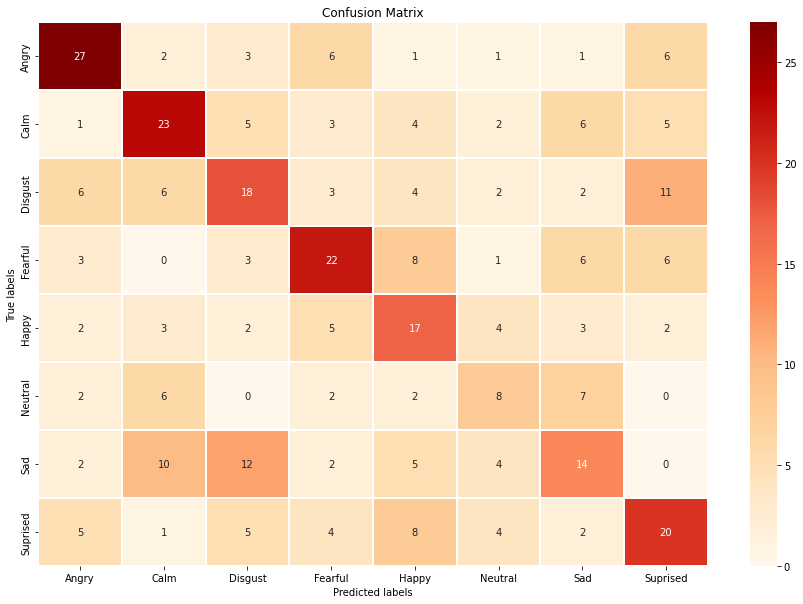

In [31]:
#Plot confusion matrix
cf_matrix(y_preds,y_test)

#### Convolutional Nueral Net (CNN)

In [32]:
#Develop model
model = models.Sequential()
model.add(Conv1D(264, kernel_size=5, strides=1,  activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=5, strides = 2))
model.add(GaussianNoise(0.1))
model.add(Conv1D(128, kernel_size=5, strides=1, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))


 # Select loss function and optimizer
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 36, 264)           1584      
_________________________________________________________________
dropout (Dropout)            (None, 36, 264)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 264)           0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 16, 264)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 128)           169088    
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0

In [33]:
#fit and train model
history = model.fit(
    X_train_sc_1,
    y_train,
    epochs=60,
    batch_size=15,
    validation_data=(X_test_sc_1, y_test)
  )


Epoch 1/60
72/72 [==============================] - 2s 24ms/step - loss: 2.0046 - accuracy: 0.1935 - val_loss: 1.9231 - val_accuracy: 0.2583
Epoch 2/60
72/72 [==============================] - 2s 21ms/step - loss: 1.9126 - accuracy: 0.2333 - val_loss: 1.8600 - val_accuracy: 0.2694
Epoch 3/60
72/72 [==============================] - 2s 21ms/step - loss: 1.8628 - accuracy: 0.2704 - val_loss: 1.8197 - val_accuracy: 0.3278
Epoch 4/60
72/72 [==============================] - 2s 21ms/step - loss: 1.8172 - accuracy: 0.2926 - val_loss: 1.7842 - val_accuracy: 0.3500
Epoch 5/60
72/72 [==============================] - 2s 21ms/step - loss: 1.7585 - accuracy: 0.3176 - val_loss: 1.7603 - val_accuracy: 0.3250
Epoch 6/60
72/72 [==============================] - 1s 21ms/step - loss: 1.7095 - accuracy: 0.3481 - val_loss: 1.7219 - val_accuracy: 0.3722
Epoch 7/60
72/72 [==============================] - 2s 21ms/step - loss: 1.6504 - accuracy: 0.3713 - val_loss: 1.6529 - val_accuracy: 0.4083
Epoch 8/60
72

34/34 [==============================] - 0s 6ms/step - loss: 0.0342 - accuracy: 0.9889
Train Accuracy :  98.88888597488403 %
12/12 [==============================] - 0s 6ms/step - loss: 1.7207 - accuracy: 0.6389
Test Accuracy :  63.88888955116272 %


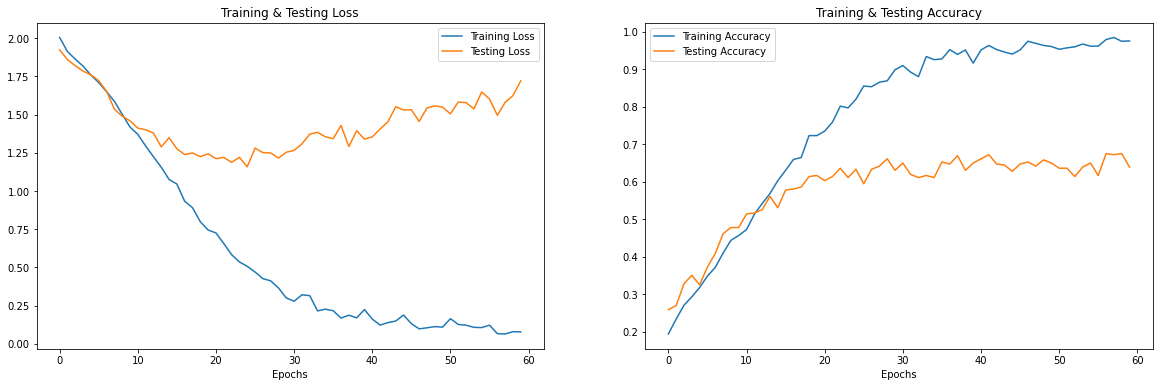

In [34]:
#Show nueral net performance
print("Train Accuracy : " , model.evaluate(X_train_sc_1,y_train)[1]*100 , "%")
print("Test Accuracy : " , model.evaluate(X_test_sc_1,y_test)[1]*100 , "%")

epochs = [i for i in range(60)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [35]:
#Predict on test data
y_predictions = model.predict(X_test_sc_1).argmax(axis=1)

#Print classification report
print(classification_report(y_test,y_predictions, target_names=levels))


              precision    recall  f1-score   support

       Angry       0.85      0.48      0.61        48
        Calm       0.71      0.90      0.79        51
     Disgust       0.58      0.52      0.55        48
     Fearful       0.68      0.68      0.68        47
       Happy       0.50      0.67      0.57        49
     Neutral       0.59      0.38      0.47        26
         Sad       0.52      0.66      0.58        41
    Suprised       0.79      0.68      0.73        50

    accuracy                           0.64       360
   macro avg       0.65      0.62      0.62       360
weighted avg       0.66      0.64      0.64       360



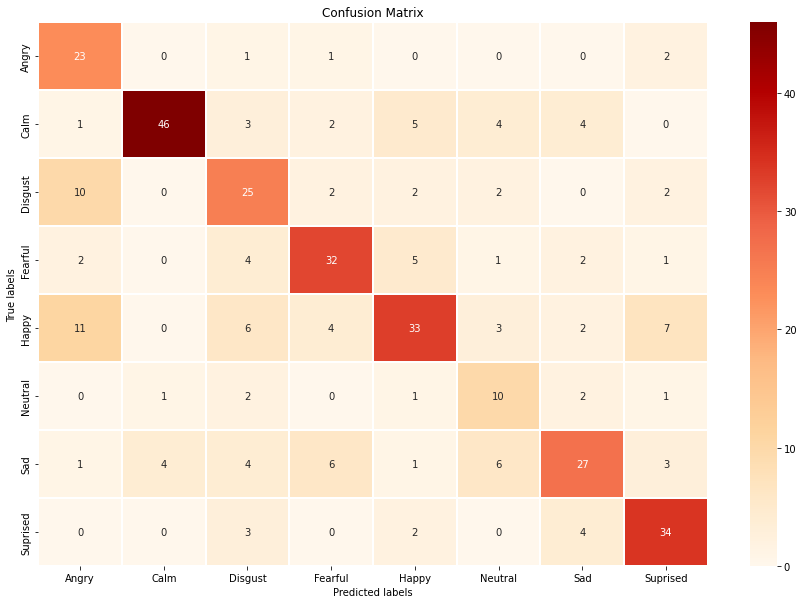

In [36]:
#Plot confusion matrix
cf_matrix(y_predictions,y_test)

In [37]:
#Save Model

save_format='h5'
model.save("Chosen_Model.h5")